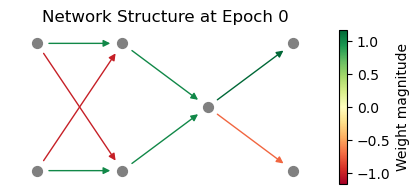

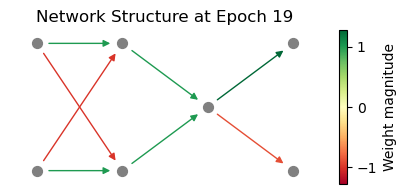

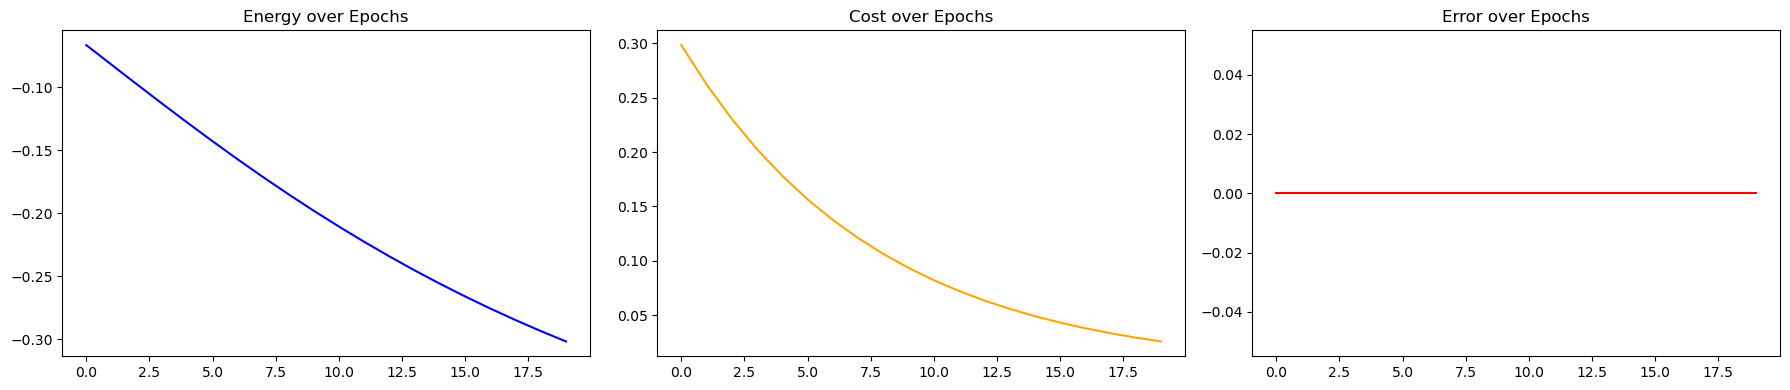

err 0.0


In [ ]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

from ebm.train_model import *


import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve

class ExternalWorld:
    def __init__(self, x_values, y_values, size_dataset=None):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = size_dataset if size_dataset is not None else len(self.x)

class MNISTExternalWorld(ExternalWorld):
    def __init__(self):
        dir_path = os.path.dirname(os.path.abspath(__file__))
        path = os.path.join(dir_path, "mnist.pkl.gz")

        # DOWNLOAD MNIST DATASET if it does not exist.
        if not os.path.isfile(path):
            origin = "http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz"
            print(f"Downloading data from {origin}")
            urlretrieve(origin, path)

        # LOAD MNIST DATASET
        with gzip.open(path, "rb") as f:
            # For Python 3, use encoding='latin1' to load the pickle.
            train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
        
        train_x_values, train_y_values = train_set
        valid_x_values, valid_y_values = valid_set
        test_x_values, test_y_values = test_set

        # CONCATENATE all splits.
        x_values = np.concatenate([train_x_values, valid_x_values, test_x_values], axis=0)
        y_values = np.concatenate([train_y_values, valid_y_values, test_y_values], axis=0)

        super().__init__(x_values, y_values)


import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import time
import json
from pathlib import Path

class EnergyBasedModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, optimizer, beta=0.1, dt=0.1, n_steps=20, debug=False):
        """
        Initialize an Energy-Based Model with equilibrium propagation.
        
        Args:
            input_size (int): Size of input layer
            hidden_sizes (list): List of hidden layer sizes
            optimizer: PyTorch optimizer (will be set separately)
            beta (float): Influence of the output cost on the energy
            dt (float): Time step for dynamics
            n_steps (int): Number of steps for reaching equilibrium
            debug (bool): Whether to enable debugging mode
        """
        super().__init__()
        
        self.layer_sizes = [input_size] + hidden_sizes
        self.beta = beta
        self.dt = dt
        self.n_steps = n_steps
        self.training_mode = False
        self.debug = debug
        self.debug_log = {}
        
        # Initialize weights and biases for symmetric connections
        # We use separate weights for forward and backward to maintain symmetry explicitly
        self.weights = nn.ParameterList([
            nn.Parameter(
                torch.randn(self.layer_sizes[i], self.layer_sizes[i+1]) / 
                torch.sqrt(torch.tensor(self.layer_sizes[i]))
            ) for i in range(len(self.layer_sizes)-1)
        ])
        
        # Initialize biases for each layer
        self.biases = nn.ParameterList([
            nn.Parameter(torch.zeros(size))
            for size in self.layer_sizes[1:]
        ])
        
        # States will be initialized during forward pass based on batch size
        self.states = None
        
        # Initialize optimizer
        self.optimizer = None
        
        # Debug log directory
        self.log_dir = Path('debug_logs')
        if self.debug:
            self.log_dir.mkdir(exist_ok=True)
            self.debug_iteration = 0
    
    def enable_debug(self):
        """Enable debug mode"""
        self.debug = True
        self.log_dir = Path('debug_logs')
        self.log_dir.mkdir(exist_ok=True)
        self.debug_iteration = 0
        print("Debug mode enabled. Logs will be saved to:", self.log_dir.absolute())
        
    def disable_debug(self):
        """Disable debug mode"""
        self.debug = False
        print("Debug mode disabled.")
    
    def reset_debug_log(self):
        """Reset the debug log"""
        self.debug_log = {}
        self.debug_iteration = 0
    
    def log_state(self, name, value, step=None):
        """Log a state value for debugging"""
        if not self.debug:
            return
            
        if isinstance(value, torch.Tensor):
            # Convert tensor to numpy for logging
            value_np = value.detach().cpu().numpy()
            
            # Handle different tensor dimensions
            if value_np.ndim == 0:  # scalar
                value_to_log = float(value_np)
            elif value_np.ndim == 1:  # vector
                if len(value_np) > 10:  # if vector is long, log summary stats
                    value_to_log = {
                        'mean': float(np.mean(value_np)),
                        'std': float(np.std(value_np)),
                        'min': float(np.min(value_np)),
                        'max': float(np.max(value_np)),
                        'shape': list(value_np.shape)
                    }
                else:
                    value_to_log = value_np.tolist()
            else:  # matrix or higher
                value_to_log = {
                    'mean': float(np.mean(value_np)),
                    'std': float(np.std(value_np)),
                    'min': float(np.min(value_np)),
                    'max': float(np.max(value_np)),
                    'shape': list(value_np.shape)
                }
        else:
            value_to_log = value
            
        if step is None:
            step = self.debug_iteration
            
        if name not in self.debug_log:
            self.debug_log[name] = {}
            
        self.debug_log[name][step] = value_to_log
    
    def save_debug_log(self, prefix='debug'):
        """Save the debug log to a file"""
        if not self.debug or not self.debug_log:
            return
            
        timestamp = time.strftime('%Y%m%d_%H%M%S')
        filepath = self.log_dir / f"{prefix}_{timestamp}.json"
        
        with open(filepath, 'w') as f:
            json.dump(self.debug_log, f, indent=2)
            
        print(f"Debug log saved to {filepath}")
        
        # Reset log after saving
        self.reset_debug_log()
    
    def gradient(self, inputs):
        first_states, second_states = inputs
        
        weights_gradients = []
        biases_gradients = []
        
        if self.debug:
            print(f"\n--- Computing Gradients (Iteration {self.debug_iteration}) ---")
            self.log_state("gradient_inputs/first_states", [s.mean().item() for s in first_states])
            self.log_state("gradient_inputs/second_states", [s.mean().item() for s in second_states])
        
        for i in range(len(self.weights)):
            # Compute batch-wise outer products and take mean over batch dimension
            weight_grad = (torch.bmm(second_states[i+1].unsqueeze(2), second_states[i].unsqueeze(1)) - 
                         torch.bmm(first_states[i+1].unsqueeze(2), first_states[i].unsqueeze(1))).mean(0) / self.beta
            weights_gradients.append(weight_grad)
            
            bias_grad = (second_states[i+1] - first_states[i+1]).mean(dim=0)
            biases_gradients.append(bias_grad)
            
            if self.debug:
                print(f"  Layer {i}: Weight grad stats - Mean: {weight_grad.mean().item():.6f}, "
                      f"Std: {weight_grad.std().item():.6f}, "
                      f"Min: {weight_grad.min().item():.6f}, "
                      f"Max: {weight_grad.max().item():.6f}")
                print(f"  Layer {i}: Bias grad stats   - Mean: {bias_grad.mean().item():.6f}, "
                      f"Std: {bias_grad.std().item():.6f}, "
                      f"Min: {bias_grad.min().item():.6f}, "
                      f"Max: {bias_grad.max().item():.6f}")
                
                self.log_state(f"gradient/weight_{i}", weight_grad)
                self.log_state(f"gradient/bias_{i}", bias_grad)

        return weights_gradients, biases_gradients

    def energy(self, states, inputs, targets=None):
        """
        Compute the total energy of the network.
        
        Args:
            states (list): List of state tensors for each layer [batch_size x layer_size]
            inputs (torch.Tensor): Input data [batch_size x input_size]
            targets (torch.Tensor, optional): Target data [batch_size x output_size]
        
        Returns:
            torch.Tensor: Total energy of the network averaged over batch
        """
        energy = 0.0
        
        # Input clamping energy
        input_energy = 0.5 * torch.mean(torch.sum((states[0] - inputs) ** 2, dim=1))
        energy += input_energy
        
        weight_energies = []
        bias_energies = []
        saturation_energies = []
        
        # Symmetric weight contributions
        for i in range(len(self.weights)):
            # Batch matrix multiplication
            weight_energy = -torch.mean(torch.sum(states[i] @ self.weights[i] * states[i+1], dim=1))
            energy += weight_energy
            weight_energies.append(weight_energy.item())
            
            # Add bias terms
            bias_energy = -torch.mean(torch.sum(states[i+1] * self.biases[i], dim=1))
            energy += bias_energy
            bias_energies.append(bias_energy.item())
            
            # Saturation cost (using soft bounds)
            sat_energy = torch.mean(torch.sum(F.softplus(states[i+1]) + F.softplus(-states[i+1]), dim=1))
            energy += sat_energy
            saturation_energies.append(sat_energy.item())
        
        # Add supervised cost if targets are provided
        target_energy = 0.0
        if targets is not None:
            target_energy = self.beta * 0.5 * torch.mean(torch.sum((states[-1] - targets) ** 2, dim=1))
            energy += target_energy
        
        if self.debug:
            print(f"\n--- Energy Calculation (Iteration {self.debug_iteration}) ---")
            print(f"  Input clamping energy: {input_energy.item():.6f}")
            for i in range(len(self.weights)):
                print(f"  Layer {i}: Weight energy: {weight_energies[i]:.6f}, "
                      f"Bias energy: {bias_energies[i]:.6f}, "
                      f"Saturation energy: {saturation_energies[i]:.6f}")
            if targets is not None:
                print(f"  Target energy (beta={self.beta}): {target_energy.item():.6f}")
            print(f"  Total energy: {energy.item():.6f}")
            
            self.log_state("energy/input", input_energy.item())
            self.log_state("energy/weight", weight_energies)
            self.log_state("energy/bias", bias_energies)
            self.log_state("energy/saturation", saturation_energies)
            if targets is not None:
                self.log_state("energy/target", target_energy.item())
            self.log_state("energy/total", energy.item())
            
        return energy
    
    def cost(self, output, target, beta=0, grad=True):
        if grad:
            cost_value = beta * (output - target)
            if self.debug:
                self.log_state("cost/grad", cost_value)
            return cost_value
        else:
            cost_value = 0.5 * torch.mean(torch.sum((output - target) ** 2, dim=1)).item()
            if self.debug:
                self.log_state("cost/value", cost_value)
            return cost_value
    
    def activation(self, x):
        activated = torch.sigmoid(x)
        if self.debug:
            self.log_state("activation/pre", x)
            self.log_state("activation/post", activated)
        return activated
    
    def negative(self, input, target=None, beta=0):
        batch_size = input.shape[0]
        
        # Initialize states with proper batch dimension if not done
        if self.states is None or self.states[0].shape[0] != batch_size:
            self.states = [torch.zeros(batch_size, size, device=input.device) for size in self.layer_sizes]
            
        # Clamp input
        self.states[0] = input.clone()
        
        if self.debug:
            print(f"\n--- Negative Phase (Iteration {self.debug_iteration}, Beta={beta}) ---")
            print(f"  Input shape: {input.shape}, Batch size: {batch_size}")
            print(f"  Target: {'Provided' if target is not None else 'None'}")
            self.log_state("negative/input", input)
            if target is not None:
                self.log_state("negative/target", target)
            
            # Log initial states
            for i, state in enumerate(self.states):
                self.log_state(f"negative/initial_state_{i}", state)
        
        # Fixed point iterations
        for step in range(self.n_steps):
            old_states = [s.clone() for s in self.states]
            
            for i in range(1, len(self.layer_sizes)):
                pre_activation = self.states[i-1] @ self.weights[i-1] + self.biases[i-1]
                
                if beta != 0 and i == len(self.layer_sizes)-1 and target is not None:
                    cost_grad = self.cost(self.states[i], target, beta, grad=True)
                    pre_activation += cost_grad
                    
                    if self.debug and step == 0:
                        print(f"  Adding cost gradient to layer {i}, magnitude: {cost_grad.abs().mean().item():.6f}")
                
                self.states[i] = self.activation(pre_activation)
            
            # Calculate state changes for convergence monitoring
            if self.debug:
                state_changes = [torch.mean(torch.abs(self.states[i] - old_states[i])).item() 
                              for i in range(1, len(self.states))]
                avg_change = sum(state_changes) / len(state_changes)
                
                if step % 5 == 0 or step == self.n_steps - 1:
                    print(f"  Step {step+1}/{self.n_steps}: Avg state change: {avg_change:.6f}")
                    
                self.log_state(f"negative/step_{step}/changes", state_changes)
                
                # Log states periodically
                if step % 5 == 0 or step == self.n_steps - 1:
                    for i, state in enumerate(self.states):
                        self.log_state(f"negative/step_{step}/state_{i}", state)
        
        if self.debug:
            # Calculate final energy
            energy = self.energy(self.states, input, target if beta > 0 else None)
            print(f"  Final energy: {energy.item():.6f}")
            
            # Log final states
            for i, state in enumerate(self.states):
                self.log_state(f"negative/final_state_{i}", state)
        
        return [s.clone() for s in self.states]
    
    def train(self):
        self.training_mode = True
        return self
    
    def eval(self):
        self.training_mode = False
        return self
    
    def forward(self, input, target=None, beta=0):
        if self.training_mode:
            if self.optimizer is None:
                raise ValueError("Optimizer not set. Please set optimizer before training.")
            
            if self.debug:
                self.debug_iteration += 1
                print(f"\n============ Forward Pass (Iteration {self.debug_iteration}) ============")
                print(f"Input shape: {input.shape}, Target: {'Provided' if target is not None else 'None'}")
                print(f"Model state: {'Training' if self.training_mode else 'Evaluation'}")
                self.log_state("forward/input", input)
                if target is not None:
                    self.log_state("forward/target", target)
            
            self.optimizer.zero_grad()

            # First Energy Minimization without cost
            if self.debug:
                print("\nRunning first phase (free phase) with beta=0")
            first_states = self.negative(input, target)

            # Second Energy Minimization with cost
            if self.debug:
                print(f"\nRunning second phase (clamped phase) with beta={self.beta}")
            second_states = self.negative(input, target, beta=self.beta)

            # Compute gradients
            if self.debug:
                print("\nComputing weight and bias gradients from equilibrium states")
            weights_gradients, biases_gradients = self.gradient((first_states, second_states))

            # Update weights and biases
            for i in range(len(self.weights)):
                self.weights[i].grad = weights_gradients[i].T
                self.biases[i].grad = biases_gradients[i]
                
                if self.debug:
                    weight_grad_norm = torch.norm(self.weights[i].grad).item()
                    bias_grad_norm = torch.norm(self.biases[i].grad).item()
                    print(f"  Layer {i}: Weight grad norm: {weight_grad_norm:.6f}, "
                          f"Bias grad norm: {bias_grad_norm:.6f}")
                    self.log_state(f"forward/weight_grad_norm_{i}", weight_grad_norm)
                    self.log_state(f"forward/bias_grad_norm_{i}", bias_grad_norm)

            if self.debug:
                print("\nApplying optimizer step")
                # Log parameter stats before update
                for i, w in enumerate(self.weights):
                    self.log_state(f"forward/pre_update_weight_{i}", w)
                for i, b in enumerate(self.biases):
                    self.log_state(f"forward/pre_update_bias_{i}", b)
                
            self.optimizer.step()
            
            if self.debug:
                # Log parameter stats after update
                for i, w in enumerate(self.weights):
                    self.log_state(f"forward/post_update_weight_{i}", w)
                for i, b in enumerate(self.biases):
                    self.log_state(f"forward/post_update_bias_{i}", b)
                    
                # Calculate weight change magnitude
                for i in range(len(self.weights)):
                    pre = self.debug_log[f"forward/pre_update_weight_{i}"][self.debug_iteration]
                    post = self.debug_log[f"forward/post_update_weight_{i}"][self.debug_iteration]
                    if isinstance(pre, dict) and 'mean' in pre:
                        change = post['mean'] - pre['mean']
                    else:
                        change = np.mean(np.array(post) - np.array(pre))
                    print(f"  Layer {i}: Avg weight change: {change:.8f}")
                
                print("\nForward pass complete")
                
                # Log output
                self.log_state("forward/output", second_states[-1])
                
                # Save logs periodically
                if self.debug_iteration % 10 == 0:
                    self.save_debug_log(prefix=f"iter_{self.debug_iteration}")
            
            return second_states[-1]
        else:
            # Evaluation mode - just do one forward pass without cost
            if self.debug:
                self.debug_iteration += 1
                print(f"\n============ Evaluation Pass (Iteration {self.debug_iteration}) ============")
                print(f"Input shape: {input.shape}")
                self.log_state("eval/input", input)
                
            states = self.negative(input)
            
            if self.debug:
                self.log_state("eval/output", states[-1])
                if self.debug_iteration % 10 == 0:
                    self.save_debug_log(prefix=f"eval_{self.debug_iteration}")
                    
            return states[-1]



import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import pickle
from util.activation import *
from util.energy import *

class Network:
    def __init__(self, name, external_world, hyperparameters={}):
        self.path = name + ".save"
        self.external_world = external_world
        self.hyperparameters = hyperparameters

        input_size = external_world.x.shape[1]
        output_size = hyperparameters.get("output_size", len(torch.unique(external_world.y)))
        layer_sizes = [input_size] + hyperparameters["hidden_sizes"] + [output_size]
        self.clamped_layers = [0]

        self.biases, self.weights, self.training_curves = self._initialize_params(layer_sizes)
        self.batch_size = hyperparameters["batch_size"]
        self.dataset_size = external_world.size_dataset
        self.persistent_particles = [torch.zeros((self.dataset_size, size)) for size in layer_sizes[1:]]
        self.index = 0
        self.grads = []

    def _initialize_params(self, layer_sizes):
        biases = [torch.zeros(size) for size in layer_sizes]
        weights = [torch.tensor(np.random.uniform(-np.sqrt(6 / (n_in + n_out)), 
                        np.sqrt(6 / (n_in + n_out)), (n_in, n_out)), dtype=torch.float32)
                   for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        return biases, weights, {"training error": [], "validation error": []}

    def update_mini_batch_index(self, index):
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        self.x_data, self.y_data = self.external_world.x[start:end], self.external_world.y[start:end]
        #print(self.x_data.shape)
        output_size = self.hyperparameters["output_size"]
        self.y_data_one_hot = F.one_hot(self.y_data, num_classes=output_size).float()
        self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]

    def energy(self, layers):
        """Compute the energy function E for the current layers."""
        energy_fn = self.hyperparameters["energy_fn"] if "energy_fn" in self.hyperparameters else "hopfield"

        if energy_fn == 'none':
            pass
        elif energy_fn == 'hopfield':
            return hopfield(layers, self.weights, self.biases)
        else:
            raise ValueError('Unknown energy function type: {}'.format(energy_fn))

    def cost(self, layers):
        # Squared error cost between the last layer and the one-hot labels.
        return ((layers[-1] - self.y_data_one_hot) ** 2).sum(dim=1)
    
    def activation(self, neurons):
        """Compute the activation of the given neurons' values."""
        activation = self.hyperparameters["activation"] if "activation" in self.hyperparameters else "pi"
        return get_activation(activation, neurons)
    
    def measure(self):
        """Measure the average energy, cost, and error over the current mini-batch."""
        E = self.energy(self.layers).mean().item()
        C = self.cost(self.layers).mean().item()
        # y_prediction = self.layers[-1].argmax(dim=1)
        # error = (y_prediction != self.y_data).float().mean().item()

        y_pred = self.layers[-1]
        top_vals, top_idxs = y_pred.topk(2, dim=1)

        # Check if the top prediction is ahead of the second by at least 1e-8
        confident = (top_vals[:, 0] - top_vals[:, 1]) > 1e-3
        correct = (top_idxs[:, 0] == self.y_data) & confident

        error = (~correct).float().mean().item()

        return E, C, error
    
    def forward(self, dataloader, n_iterations):
        """Perform forward pass with negative phase relaxation on a given dataloader."""
        total_energy = 0
        total_cost = 0
        total_error = 0
        n_batches = 0
        
        # Store original persistent particles
        original_particles = [p.clone() for p in self.persistent_particles]
        
        x,y = dataloader
        n_batches = x.shape[0]
        # Move data to device and prepare one-hot labels
        self.x_data = x
        self.y_data = y
        self.y_data_one_hot = F.one_hot(self.y_data, num_classes=self.weights[-1].shape[1]).float()
        
        # Initialize layers for this batch
        print(self.x_data.shape)
        self.layers = [self.x_data] + [p[:x.size(0)] for p in self.persistent_particles]
        
        # Perform negative phase
        self.negative_phase(n_iterations)
        
        # Measure metrics
        E, C, error = self.measure()
        total_energy += E
        total_cost += C
        total_error += error

        
        # Restore original persistent particles
        self.persistent_particles = original_particles
        
        # Return average metrics
        return (total_energy / n_batches, 
                total_cost / n_batches, 
                total_error / n_batches)

    def negative_phase(self, n_iterations):
        """Perform the negative phase relaxation (forward pass)."""
        # Copy the current mini-batch layers to iterate on.
        current_layers = [layer.clone() for layer in self.layers]
        for _ in range(n_iterations):
            new_layers = [torch.zeros(i.shape) for i in self.layers]  # input layer remains clamped.
            new_layers[0] = current_layers[0]
            # For hidden layers (except the final output layer).
            # shuffle range(1, len(self.layers) - 1)
            iter_order = range(1, len(self.layers) - 1)
            for k in iter_order:
                hidden_input = (torch.matmul(new_layers[k-1], self.weights[k - 1]) +
                                torch.matmul(current_layers[k + 1], self.weights[k].t()) +
                                self.biases[k])
                # Batch normalization
                hidden_input = self.activation(hidden_input)
                # Min-max normalization to [0,1] range
                min_val = hidden_input.min(dim=0)[0]
                max_val = hidden_input.max(dim=0)[0]
                hidden_input = (hidden_input - min_val) / (max_val - min_val + 1e-5)  # Add epsilon to avoid division by zero
                #print(f"hidden_input mean: {hidden_input.mean():.4f}, std: {hidden_input.std():.4f}, max: {hidden_input.max():.4f}, min: {hidden_input.min():.4f}")
                # Batch normalization using mean and std
                # mean = hidden_input.mean(dim=0)
                # std = hidden_input.std(dim=0) + 1e-5
                # hidden_input = (hidden_input - mean) / std
                hidden_input = hidden_input - hidden_input.mean(dim=0)
                #print(f"hidden_input mean: {hidden_input.mean():.4f}, std: {hidden_input.std():.4f}, max: {hidden_input.max():.4f}, min: {hidden_input.min():.4f}")
                new_layers[k]=(hidden_input)
            # Compute output layer.3:45pm
            output_input = torch.matmul(new_layers[-2], self.weights[-1]) + self.biases[-1]
            new_layers[-1] = self.activation(output_input)
            current_layers = new_layers
        # Update the persistent particles for the current mini-batch.
        start = self.index * self.batch_size
        end = (self.index + 1) * self.batch_size
        for i in range(len(self.persistent_particles)):
            self.persistent_particles[i][start:end] = current_layers[i + 1].detach()
        self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]
    
    def positive_phase(self, n_iterations, *alphas):
        """Perform the positive phase (backprop-like relaxation and parameter update)."""
        batch_size = self.x_data.shape[0]
        # Initialize the backprop scan: all layers except last remain unchanged,
        # and the final layer is replaced by the clamped one-hot label.
        initial_layers = self.layers[:-1] + [self.y_data_one_hot]
        current_layers = [layer.clone() for layer in initial_layers]
        for _ in range(n_iterations):
            new_layers = [current_layers[-1]]  # start with the top layer.
            # Backpropagate from the top hidden layer to the second layer.
            for k in range(len(self.layers) - 2, 0, -1):
                back_input = (torch.matmul(self.layers[k - 1], self.weights[k - 1]) +
                              torch.matmul(new_layers[-1], self.weights[k].t()) +
                              self.biases[k])
                back_input = self.activation(back_input)
                # Min-max normalization to [0,1] range
                min_val = back_input.min(dim=0)[0]
                max_val = back_input.max(dim=0)[0]
                back_input = (back_input - min_val) / (max_val - min_val + 1e-5)  # Add epsilon to avoid division by zero
                # back_input = back_input - 0.5 / 0.5
                back_input = back_input - back_input.mean(dim=0)
                # Batch normalization using mean and std
                # mean = back_input.mean(dim=0)
                # std = back_input.std(dim=0) + 1e-5
                # back_input = (back_input - mean) / std
                #print(f"back_input mean: {back_input.mean():.4f}, std: {back_input.std():.4f}, max: {back_input.max():.4f}, min: {back_input.min():.4f}")
                new_layers.append(back_input)
            new_layers.append(self.layers[0])
            new_layers.reverse()
            current_layers = new_layers
        # Compute the difference (Delta) between the new layers and the persistent ones (skipping the input).
        Delta_layers = [new - old for new, old in zip(current_layers[1:], self.layers[1:])]
        #print(f"Delta_layers mean: {Delta_layers[0].mean():.4f}, std: {Delta_layers[0].std():.4f}, max: {Delta_layers[0].max():.4f}, min: {Delta_layers[0].min():.4f}")
        # Update biases for layers 1 to end.
        for i, delta in enumerate(Delta_layers, start=1):
            self.biases[i] = self.biases[i] + alphas[i - 1] * delta.mean(dim=0)
        #
        # Update weights for each connection.
        
        for i, delta in enumerate(Delta_layers):
            self.weights[i] = (self.weights[i] + alphas[i] * (self.layers[i].t() @ delta) / batch_size )
            grads = self.layers[i].t()@delta
            #print(f"grads mean: {grads.mean():.4f}, std: {grads.std():.4f}, max: {grads.max():.4f}, min: {grads.min():.4f}")
        
    def backward(self,output, n_iterations=10,clamped_layers=[-1]):
        """Perform the negative phase relaxation (forward pass)."""
        # Copy the current mini-batch layers to iterate on.
        current_layers = [layer.clone() for layer in self.layers]
        current_layers[-1] = output
        for _ in range(n_iterations):
            new_layers = [torch.zeros(i.shape) for i in self.layers]  # input layer remains clamped.
            for i in clamped_layers: new_layers[i] = current_layers[i]
            # For hidden layers (except the final output layer).
            # shuffle range(1, len(self.layers) - 1)
            iter_order = np.random.permutation(range(1, len(self.layers) - 1))
            for k in iter_order:
                hidden_input = (torch.matmul(new_layers[k-1], self.weights[k - 1]) +
                                torch.matmul(current_layers[k + 1], self.weights[k].t()) +
                                self.biases[k])
                new_layers[k]=(self.activation(hidden_input))
                # Batch normalization using mean and std
                # mean = new_layers[k].mean(dim=0)
                # std = new_layers[k].std(dim=0) + 1e-5
                # new_layers[k] = (new_layers[k] - mean) / std
                # Min-max normalization to [0,1] range
                min_val = new_layers[k].min(dim=0)[0]
                max_val = new_layers[k].max(dim=0)[0]
                new_layers[k] = (new_layers[k] - min_val) / (max_val - min_val + 1e-5)  # Add epsilon to avoid division by zero
                # new_layers[k] = new_layers[k] - new_layers[k].mean(dim=0)
            # Compute output layer.
            output_input = torch.matmul(new_layers[1], self.weights[0].T) + self.biases[0]
            new_layers[0] = self.activation(output_input)
            current_layers = new_layers
        # Update the persistent particles for the current mini-batch.
        start = self.index * self.batch_size
        end = (self.index + 1) * self.batch_size
        for i in range(len(self.persistent_particles)):
            self.persistent_particles[i][start:end] = current_layers[i + 1].detach()
        self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]
        return current_layers[0]

    def save_params(self):
        biases_values = [b.detach().numpy() for b in self.biases]
        weights_values = [W.detach().numpy() for W in self.weights]
        to_dump = (biases_values, weights_values, self.hyperparameters, self.training_curves)
        with open(self.path, "wb") as f:
            pickle.dump(to_dump, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def __load_params(self, hyperparameters):
        hyper = hyperparameters.copy()
        if os.path.isfile(self.path):
            with open(self.path, "rb") as f:
                biases_values, weights_values, saved_hyper, training_curves = pickle.load(f)
            saved_hyper.update(hyper)
            hyper = saved_hyper
        else:
            layer_sizes = [28 * 28] + hyper["hidden_sizes"] + [10]
            biases_values = [np.zeros((size,), dtype=np.float32) for size in layer_sizes]
            weights_values = []
            # Glorot/Bengio weight initialization for each layer.
            for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
                limit = np.sqrt(6.0 / (n_in + n_out))
                W = np.random.uniform(low=-limit, high=limit, size=(n_in, n_out)).astype(np.float32)
                weights_values.append(W)
            training_curves = {"training error": [], "validation error": []}
        
        # Convert loaded parameters to torch tensors.
        biases = [torch.tensor(b, dtype=torch.float32) for b in biases_values]
        weights = [torch.tensor(W, dtype=torch.float32) for W in weights_values]
        return biases, weights, hyper, training_curves








def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 2, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        if(plot_graph):
            if epoch in snapshot_epochs:
            # if(history["Error"][-1]< 0.001):
                plot_network_weights(net, epoch)
                # visualize_all_samples(net)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res



import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)



xor_net = Network(
            name=f"xor_trial",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 20,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1,0.1,0.1],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

init = [-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)


# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= True))





In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

def draw_energy_graph_3d(net, sample_idx, x_gap=8.0, y_gap=5.0, z_scale=300.0):
    def compute_layout_2d(layer_sizes):
        pos = {}
        for i, size in enumerate(layer_sizes):
            offset = (size - 1) * y_gap / 2
            for j in range(size):
                jitter = 0.3 if j % 2 == 0 else -0.3
                pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
        return pos

    def compute_node_energies(net, sample_idx):
        activations = [layer[sample_idx] for layer in net.layers]
        biases = net.biases
        weights = net.weights
        node_energy = {}
        for i in range(len(activations)):
            for j in range(len(activations[i])):
                a = activations[i][j].item()
                b = biases[i][j].item()
                node_energy[(i, j)] = -b * a if i > 0 else 0.0
        for idx, W in enumerate(weights):
            a_src = activations[idx]
            a_tgt = activations[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    contrib = -a_src[i].item() * W[i, j].item() * a_tgt[j].item()
                    node_energy[(idx, i)] += 0.5 * contrib
                    node_energy[(idx + 1, j)] += 0.5 * contrib
        return node_energy

    def build_energy_graph(net, sample_idx):
        G = nx.DiGraph()
        acts = [layer[sample_idx] for layer in net.layers]
        parts = [p[sample_idx] for p in net.persistent_particles]
        y = net.y_data[sample_idx].item()
        node_energy = compute_node_energies(net, sample_idx)
        layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
        labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                a = acts[i][j].item()
                b = net.biases[i][j].item()
                post = a + b if i > 0 else a
                p = parts[i - 1][j].item() if i > 0 else 0.0
                out = a if i == len(layer_sizes) - 1 else None
                label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
                if out is not None:
                    label += f"\nŷ={out:.2f} y={y}"
                G.add_node((i, j), activation=a, bias=b, label=label, particle=p, energy=node_energy[(i, j)], layer=i)
        for idx, W in enumerate(net.weights):
            a_src = acts[idx]
            a_tgt = acts[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w = W[i, j].item()
                    contrib = -a_src[i].item() * w * a_tgt[j].item()
                    G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
        return G, layer_sizes

    def draw_layer_planes(ax, x_vals, zmin, zmax):
        for x in x_vals:
            ax.plot_surface(
                np.array([[x, x], [x, x]]),
                np.array([[-20, 20], [-20, 20]]),
                np.array([[zmin, zmin], [zmax, zmax]]),
                color='gray', alpha=0.06, zorder=-1
            )

    # def draw_energy_contours(ax, z_levels, x_range, y_range):
    #     for z in z_levels:
    #         ax.plot_surface(
    #             np.array([[x_range[0], x_range[1]], [x_range[0], x_range[1]]]),
    #             np.array([[y_range[0], y_range[0]], [y_range[1], y_range[1]]]),
    #             np.array([[z, z], [z, z]]),
    #             color='gray', alpha=0.05, zorder=-1
    #         )

    def set_axes_equal_3d(ax):
        xlim = ax.get_xlim3d()
        ylim = ax.get_ylim3d()
        zlim = ax.get_zlim3d()
        max_range = max(
            abs(xlim[1] - xlim[0]),
            abs(ylim[1] - ylim[0]),
            abs(zlim[1] - zlim[0])
        )
        for lim_setter, center in zip(
            [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d],
            [(xlim[0]+xlim[1])/2, (ylim[0]+ylim[1])/2, (zlim[0]+zlim[1])/2]
        ):
            lim_setter([center - max_range/2, center + max_range/2])

    def get_node_style(i, total_layers):
        if i == 0:
            return {'marker': 's', 'facecolor': 'skyblue'}
        elif i == total_layers - 1:
            return {'marker': '^', 'facecolor': 'salmon'}
        else:
            return {'marker': 'o', 'facecolor': 'lightgray'}

    # === Main logic ===
    G, layer_sizes = build_energy_graph(net, sample_idx)
    total_layers = len(layer_sizes)
    pos2d = compute_layout_2d(layer_sizes)
    energies = [G.nodes[n]['energy'] for n in G.nodes()]
    zs = [e * z_scale for e in energies]
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    norm_edge = mcolors.Normalize(vmin=-max(map(abs, edge_contribs)), vmax=max(map(abs, edge_contribs)))
    cmap_edge = cm.coolwarm
    cmap_particle = cm.PuBu

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70)

    # === Planes ===
    x_vals = sorted(set(pos2d[n][0] for n in G.nodes()))
    draw_layer_planes(ax, x_vals, zmin=min(zs)-4, zmax=max(zs)+4)
    # draw_energy_contours(ax,
    #                      z_levels=np.linspace(min(zs), max(zs), 8),
    #                      x_range=(min(x_vals)-4, max(x_vals)+4),
    #                      y_range=(-20, 20))

    # === Draw nodes ===
    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        z = G.nodes[(i, j)]['energy'] * z_scale
        p = G.nodes[(i, j)]['particle']
        label = G.nodes[(i, j)]['label']
        style = get_node_style(i, total_layers)
        particle_color = cmap_particle((p + 1) / 2)
        ax.scatter([x], [y], [z], s=180, marker=style['marker'],
                   color=style['facecolor'], edgecolors='black', zorder=3)
        ax.text(x, y, z + 0.5, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.8))

    # === Draw edges ===
    for u, v in G.edges():
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = G.nodes[u]['energy'] * z_scale
        z1 = G.nodes[v]['energy'] * z_scale
        c = G.edges[(u, v)]['contrib']
        label = G.edges[(u, v)]['label']
        color = cmap_edge(norm_edge(c))
        ax.plot([x0, x1], [y0, y1], [z0, z1], color=color, linewidth=2.2, alpha=0.9)
        ax.text((x0+x1)/2, (y0+y1)/2, (z0+z1)/2 + 0.3, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # === Labels, limits, scaling ===
    for i in range(total_layers):
        ax.text(i * x_gap, 0, max(zs) + 2.5, f"Layer {i}", ha='center', fontsize=9, weight='bold')

    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(energies):.4f}")

    # === Absolute limits to avoid autoscaling squash ===
    xs = [pos2d[n][0] for n in G.nodes()]
    ys = [pos2d[n][1] for n in G.nodes()]
    ax.set_xlim(min(xs) - 4, max(xs) + 4)
    ax.set_ylim(min(ys) - 4, max(ys) + 4)
    ax.set_zlim(min(zs) - 4, max(zs) + 4)
    set_axes_equal_3d(ax)

    plt.tight_layout()
    plt.show()


In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D

def draw_energy_graph_3d(net, sample_idx, x_gap=8.0, y_gap=5.0, z_scale=300.0, n_curve_pts=20):
    def compute_layout_2d(layer_sizes):
        pos = {}
        for i, size in enumerate(layer_sizes):
            offset = (size - 1) * y_gap / 2
            for j in range(size):
                jitter = 0.3 if j % 2 == 0 else -0.3
                pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
        return pos

    def compute_node_energies(net, sample_idx):
        activations = [layer[sample_idx] for layer in net.layers]
        biases = net.biases
        weights = net.weights
        node_energy = {}
        for i in range(len(activations)):
            for j in range(len(activations[i])):
                a = activations[i][j].item()
                b = biases[i][j].item()
                node_energy[(i, j)] = -b * a if i > 0 else 0.0
        for idx, W in enumerate(weights):
            a_src = activations[idx]
            a_tgt = activations[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    contrib = -a_src[i].item() * W[i, j].item() * a_tgt[j].item()
                    node_energy[(idx, i)] += 0.5 * contrib
                    node_energy[(idx + 1, j)] += 0.5 * contrib
        return node_energy

    def build_energy_graph(net, sample_idx):
        G = nx.DiGraph()
        acts = [layer[sample_idx] for layer in net.layers]
        parts = [p[sample_idx] for p in net.persistent_particles]
        y = net.y_data[sample_idx].item()
        node_energy = compute_node_energies(net, sample_idx)
        layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
        labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                a = acts[i][j].item()
                b = net.biases[i][j].item()
                post = a + b if i > 0 else a
                p = parts[i - 1][j].item() if i > 0 else 0.0
                out = a if i == len(layer_sizes) - 1 else None
                label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
                if out is not None:
                    label += f"\nŷ={out:.2f} y={y}"
                G.add_node((i, j), activation=a, bias=b, label=label, particle=p, energy=node_energy[(i, j)], layer=i)
        for idx, W in enumerate(net.weights):
            a_src = acts[idx]
            a_tgt = acts[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w = W[i, j].item()
                    contrib = -a_src[i].item() * w * a_tgt[j].item()
                    G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
        return G, layer_sizes

    def draw_layer_planes(ax, x_vals, zmin, zmax):
        for x in x_vals:
            ax.plot_surface(
                np.array([[x, x], [x, x]]),
                np.array([[-20, 20], [-20, 20]]),
                np.array([[zmin, zmin], [zmax, zmax]]),
                color='gray', alpha=0.06, zorder=-1
            )

    def set_axes_equal_3d(ax):
        xlim, ylim, zlim = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
        max_range = max(
            abs(xlim[1] - xlim[0]),
            abs(ylim[1] - ylim[0]),
            abs(zlim[1] - zlim[0])
        )
        for lim_setter, center in zip(
            [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d],
            [(xlim[0]+xlim[1])/2, (ylim[0]+ylim[1])/2, (zlim[0]+zlim[1])/2]
        ):
            lim_setter([center - max_range/2, center + max_range/2])

    def get_node_style(i, total_layers):
        if i == 0: return {'marker': 's', 'facecolor': 'skyblue'}
        elif i == total_layers - 1: return {'marker': '^', 'facecolor': 'salmon'}
        else: return {'marker': 'o', 'facecolor': 'lightgray'}

    def bezier_curve(p0, p1, mid_z, n_points=20):
        """Return n-point quadratic Bézier curve between p0 and p1 arching toward mid_z"""
        p0, p1 = np.array(p0), np.array(p1)
        midpoint = (p0 + p1) / 2
        control = np.array([midpoint[0], midpoint[1], mid_z])
        t = np.linspace(0, 1, n_points)[:, None]
        curve = (1 - t) ** 2 * p0 + 2 * (1 - t) * t * control + t ** 2 * p1
        return curve

    # === Main ===
    G, layer_sizes = build_energy_graph(net, sample_idx)
    total_layers = len(layer_sizes)
    pos2d = compute_layout_2d(layer_sizes)
    energies = [G.nodes[n]['energy'] for n in G.nodes()]
    zs = [e * z_scale for e in energies]
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    norm_edge = mcolors.Normalize(vmin=-max(map(abs, edge_contribs)), vmax=max(map(abs, edge_contribs)))
    cmap_edge = cm.coolwarm
    cmap_particle = cm.PuBu

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70)

    x_vals = sorted(set(pos2d[n][0] for n in G.nodes()))
    draw_layer_planes(ax, x_vals, zmin=min(zs)-4, zmax=max(zs)+4)

    # === Node arrows ===
    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        a = G.nodes[(i, j)]['activation']
        b = G.nodes[(i, j)]['bias']
        pre_z = a * z_scale
        post_z = (a + b) * z_scale if i > 0 else a * z_scale
        dz = post_z - pre_z

        label = G.nodes[(i, j)]['label']
        style = get_node_style(i, total_layers)
        p = G.nodes[(i, j)]['particle']
        particle_color = cmap_particle((p + 1) / 2)

        ax.quiver(x, y, pre_z, 0, 0, dz, arrow_length_ratio=0.1,
                  color=style['facecolor'], linewidth=1.5, edgecolor='black')
        ax.text(x, y, post_z + 0.5, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.8))

    # === Curved energy-decreasing edges ===
    for u, v in G.edges():
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = G.nodes[u]['energy'] * z_scale
        z1 = G.nodes[v]['energy'] * z_scale
        c = G.edges[(u, v)]['contrib']
        label = G.edges[(u, v)]['label']
        color = cmap_edge(norm_edge(c))

        # Draw curve pulling toward lower energy
        p0 = (x0, y0, z0)
        p1 = (x1, y1, z1)
        mid_z = min(z0, z1) - 0.3 * abs(z1 - z0) - 3  # bend downward more for bigger ΔE

        curve = bezier_curve(p0, p1, mid_z, n_points=n_curve_pts)
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color=color, linewidth=2.2, alpha=0.9)

        label_z = curve[n_curve_pts // 2, 2]
        ax.text((x0+x1)/2, (y0+y1)/2, label_z + 0.3, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # === Labels and scaling ===
    for i in range(total_layers):
        ax.text(i * x_gap, 0, max(zs) + 2.5, f"Layer {i}", ha='center', fontsize=9, weight='bold')

    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(energies):.4f}")

    xs = [pos2d[n][0] for n in G.nodes()]
    ys = [pos2d[n][1] for n in G.nodes()]
    ax.set_xlim(min(xs) - 4, max(xs) + 4)
    ax.set_ylim(min(ys) - 4, max(ys) + 4)
    ax.set_zlim(min(zs) - 4, max(zs) + 4)
    set_axes_equal_3d(ax)

    plt.tight_layout()
    plt.show()


In [4]:
import networkx as nx

def build_energy_graph(net, sample_idx):
    G = nx.DiGraph()

    # Gather relevant per-sample info
    activations = [layer[sample_idx] for layer in net.layers]
    particles = [p[sample_idx] for p in net.persistent_particles]
    y_label = net.y_data[sample_idx].item()
    weights = net.weights
    biases = net.biases

    # Layer sizes
    layer_sizes = [weights[0].shape[0]] + [W.shape[1] for W in weights]
    labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # === Compute energy at each node ===
    node_energy = {}
    for i, act in enumerate(activations):
        for j in range(len(act)):
            a = act[j].item()
            b = biases[i][j].item()
            e = -b * a if i > 0 else 0.0  # input layer has no bias
            node_energy[(i, j)] = e

    # === Add pairwise energy contributions to node energies ===
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                node_energy[(l, i)] += 0.5 * contrib
                node_energy[(l + 1, j)] += 0.5 * contrib

    # === Add nodes to the graph ===
    for i, size in enumerate(layer_sizes):
        for j in range(size):
            a = activations[i][j].item()
            b = biases[i][j].item()
            post = a + b if i > 0 else a
            p = particles[i - 1][j].item() if i > 0 else 0.0
            out = a if i == len(layer_sizes) - 1 else None

            label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
            if out is not None:
                label += f"\nŷ={out:.2f} y={y_label}"

            G.add_node(
                (i, j),
                activation=a,
                bias=b,
                post=post,
                particle=p,
                energy=node_energy[(i, j)],
                label=label,
                layer=i,
            )

    # === Add edges to the graph ===
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge(
                    (l, i),
                    (l + 1, j),
                    weight=w,
                    contrib=contrib,
                    label=f"{w:.2f}\nΔE={contrib:.2f}"
                )

    return G, layer_sizes


In [5]:
import matplotlib.colors as mcolors


import networkx as nx

def build_energy_graph(net, sample_idx):
    G = nx.DiGraph()

    # Gather relevant per-sample info
    activations = [layer[sample_idx] for layer in net.layers]
    particles = [p[sample_idx] for p in net.persistent_particles]
    y_label = net.y_data[sample_idx].item()
    weights = net.weights
    biases = net.biases

    # Layer sizes
    layer_sizes = [weights[0].shape[0]] + [W.shape[1] for W in weights]
    labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # === Compute energy at each node ===
    node_energy = {}
    for i, act in enumerate(activations):
        for j in range(len(act)):
            a = act[j].item()
            b = biases[i][j].item()
            e = -b * a if i > 0 else 0.0  # input layer has no bias
            node_energy[(i, j)] = e

    # === Add pairwise energy contributions to node energies ===
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                node_energy[(l, i)] += 0.5 * contrib
                node_energy[(l + 1, j)] += 0.5 * contrib

    # === Add nodes to the graph ===
    for i, size in enumerate(layer_sizes):
        for j in range(size):
            a = activations[i][j].item()
            b = biases[i][j].item()
            post = a + b if i > 0 else a
            p = particles[i - 1][j].item() if i > 0 else 0.0
            out = a if i == len(layer_sizes) - 1 else None

            label = f"{labels[i]} {j}\nPre={a:.2f} Bias={b:.2f}\nPost={post:.2f}"
            if out is not None:
                label += f"\nŷ={out:.2f} y={y_label}"

            G.add_node(
                (i, j),
                activation=a,
                bias=b,
                post=post,
                particle=p,
                energy=node_energy[(i, j)],
                label=label,
                layer=i,
            )

    # === Add edges to the graph ===
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge(
                    (l, i),
                    (l + 1, j),
                    weight=w,
                    contrib=contrib,
                    label=f"{w:.2f}\nΔE={contrib:.2f}"
                )

    return G, layer_sizes


def prepare_visual_layout(G, layer_sizes, x_gap=None, y_gap=None, z_scale=None, extent=40.0):
    pos2d = {}
    layer_xs = []

    # === Normalize x per layer ===
    n_layers = len(layer_sizes)
    x_norm = [i / (n_layers - 1) if n_layers > 1 else 0.5 for i in range(n_layers)]

    # === Build normalized (x, y) positions ===
    for i, size in enumerate(layer_sizes):
        x = x_norm[i] * extent
        layer_xs.append(x)
        y_vals = [(j / (size - 1) if size > 1 else 0.5) for j in range(size)]
        for j, y_norm in enumerate(y_vals):
            y = (1 - y_norm) * extent  # top-to-bottom
            pos2d[(i, j)] = (x, y)

    # === Energy-based z + post-bias z
    z = {}
    post_bias_zs = []
    raw_energies = []

    for n in G.nodes():
        a = G.nodes[n]['activation']
        b = G.nodes[n]['bias']
        e = G.nodes[n]['energy']
        raw_energies.append(e)
        post_val = a + b if G.nodes[n]['layer'] > 0 else a
        post_bias_zs.append(post_val)

    # Normalize z across all values
    all_z_vals = raw_energies + post_bias_zs
    z_min_raw, z_max_raw = min(all_z_vals), max(all_z_vals)
    z_range = z_max_raw - z_min_raw + 1e-6
    z_scale = extent / z_range  # stretch to match x/y scale

    # Compute final z values
    for n in G.nodes():
        z[n] = (G.nodes[n]['energy'] - z_min_raw) * z_scale
    z_min, z_max = min(z.values()), max(z.values())

    # === Normalize edge contributions
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    contrib_max = max(abs(c) for c in edge_contribs) if edge_contribs else 1.0
    edge_contrib_norm = mcolors.Normalize(vmin=-contrib_max, vmax=contrib_max)

    return {
        'pos2d': pos2d,
        'z': z,
        'z_min': z_min,
        'z_max': z_max,
        'z_scale': z_scale,
        'edge_contribs': edge_contribs,
        'color_norms': {
            'edge': edge_contrib_norm,
        },
        'layer_xs': layer_xs,
    }


def draw_nodes(ax, G, layout_info, z_scale, cmap_particle, arrow_boost=5.0):
    pos2d = layout_info['pos2d']
    z_vals = layout_info['z']
    total_layers = max(i for (i, _) in G.nodes()) + 1

    def get_marker_style(i):
        if i == 0:
            return {'marker': 's', 'color': 'skyblue'}     # Input
        elif i == total_layers - 1:
            return {'marker': '^', 'color': 'salmon'}       # Output
        else:
            return {'marker': 'o', 'color': 'lightgray'}    # Hidden

    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        a = G.nodes[(i, j)]['activation']
        b = G.nodes[(i, j)]['bias']
        post = G.nodes[(i, j)]['post']
        pre_z = a * z_scale
        post_z = post * z_scale
        dz = post_z - pre_z
        dz_vis = dz * arrow_boost

        label = G.nodes[(i, j)]['label']
        particle = G.nodes[(i, j)]['particle']
        style = get_marker_style(i)
        particle_color = cmap_particle((particle + 1) / 2)

        # Always draw the dot at post_z
        ax.scatter([x], [y], [post_z], s=100, marker=style['marker'],
                   color=style['color'], edgecolors='black', zorder=3)

        # If pre and post differ, draw an arrow
        if abs(dz) > 1e-4:
            ax.quiver(x, y, pre_z, 0, 0, dz_vis,
                      arrow_length_ratio=0.2,
                      color=style['color'], linewidth=1.5, edgecolor='black')

        # Label slightly above
        ax.text(x, y, post_z + 2.0, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.85))
        

import numpy as np

def bezier_curve(p0, p1, control, n_points=20):
    t = np.linspace(0, 1, n_points)[:, None]
    p0, p1, control = np.array(p0), np.array(p1), np.array(control)
    return (1 - t) ** 2 * p0 + 2 * (1 - t) * t * control + t ** 2 * p1

def draw_edges(ax, G, layout_info, z_scale, cmap_edge, n_curve_pts=20):
    pos2d = layout_info['pos2d']
    z_vals = layout_info['z']
    edge_norm = layout_info['color_norms']['edge']
    contribs = layout_info['edge_contribs']
    contrib_max = max(abs(c) for c in contribs) if contribs else 1.0

    for u, v in G.edges():
        # Position in 3D
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = z_vals[u]
        z1 = z_vals[v]
        contrib = G.edges[u, v]['contrib']
        label = G.edges[u, v]['label']
        color = cmap_edge(edge_norm(contrib))

        p0 = np.array([x0, y0, z0])
        p1 = np.array([x1, y1, z1])
        midpoint = (p0 + p1) / 2

        # Bend strength based on absolute contribution (normalized)
        bend_strength = abs(contrib) / contrib_max  # in [0, 1]
        bend_strength *= z_scale * 1.2  # scale into cube space

        # Bend in negative Z (downward pull)
        control = midpoint + np.array([0, 0, -bend_strength])

        # Draw curve
        curve = bezier_curve(p0, p1, control, n_points=n_curve_pts)
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color=color, linewidth=2.2, alpha=0.9)

        # Label at midpoint of curve
        mid = curve[n_curve_pts // 2]
        ax.text(mid[0], mid[1], mid[2] + 0.5, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def set_axes_equal_3d(ax):
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    max_range = max(
        abs(xlim[1] - xlim[0]),
        abs(ylim[1] - ylim[0]),
        abs(zlim[1] - zlim[0])
    )
    for setter, center in zip(
        [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d],
        [(xlim[0]+xlim[1])/2, (ylim[0]+ylim[1])/2, (zlim[0]+zlim[1])/2]
    ):
        setter([center - max_range/2, center + max_range/2])


def setup_scene(G, layout_info, z_scale, sample_idx, figsize=(18, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70)

    pos2d = layout_info['pos2d']
    z_min = layout_info['z_min']
    z_max = layout_info['z_max']
    layer_xs = layout_info['layer_xs']

    # Draw layer planes
    for x in layer_xs:
        ax.plot_surface(
            np.array([[x, x], [x, x]]),
            np.array([[-20, 20], [-20, 20]]),
            np.array([[z_min, z_min], [z_max, z_max]]),
            color='gray', alpha=0.06, zorder=-1
        )

    # Axis limits and labels
    xs = [pos2d[n][0] for n in G.nodes()]
    ys = [pos2d[n][1] for n in G.nodes()]
    ax.set_xlim(min(xs) - 4, max(xs) + 4)
    ax.set_ylim(min(ys) - 4, max(ys) + 4)
    ax.set_zlim(z_min - 4, z_max + 4)

    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(G.nodes[n]['energy'] for n in G.nodes()):.4f}")

    set_axes_equal_3d(ax)
    return fig, ax


def draw_energy_graph_3d(net, sample_idx, x_gap=8.0, y_gap=5.0, z_scale=None):
    # Build graph and compute layout
    G, layer_sizes = build_energy_graph(net, sample_idx)
    layout_info = prepare_visual_layout(G, layer_sizes, x_gap, y_gap, z_scale)

    # Extract the z_scale actually used
    z_scale = layout_info['z_scale']

    # Colormaps
    cmap_particle = plt.get_cmap('PuBu')
    cmap_edge = plt.get_cmap('coolwarm')

    # Setup scene and draw
    fig, ax = setup_scene(G, layout_info, z_scale, sample_idx)
    draw_nodes(ax, G, layout_info, z_scale, cmap_particle)
    draw_edges(ax, G, layout_info, z_scale, cmap_edge)

    plt.tight_layout()
    plt.show()

def visualize_all_samples(net):
    for sample_idx in range(len(net.x_data)):
        draw_energy_graph_3d(net, sample_idx)



In [6]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import numpy as np
from typing import Any, Dict, List, Tuple, Optional

# Type definition for network object (assuming common attributes)
# Replace with actual type if available
NetworkType = Any

# --- Constants ---
DEFAULT_EXTENT = 40.0
DEFAULT_FIGSIZE = (18, 10)
ARROW_BOOST_FACTOR = 5.0
EDGE_CURVE_POINTS = 20
LAYER_PLANE_ALPHA = 0.06
LAYER_PLANE_Y_RANGE = (-20, 20) # Adjust if needed based on typical node counts
LABEL_Z_OFFSET = 2.0
NODE_LABEL_ALPHA = 0.85
EDGE_LABEL_PAD = 0.2
EDGE_LINEWIDTH = 2.2
EDGE_ALPHA = 0.9
NODE_MARKER_SIZE = 100
NODE_ARROW_LINEWIDTH = 1.5
NODE_LABEL_FONTSIZE = 7
EDGE_LABEL_FONTSIZE = 6
EPSILON = 1e-6 # For safe division

# --- Helper Functions ---

def _calculate_node_energies(activations: List[np.ndarray], weights: List[np.ndarray], biases: List[np.ndarray]) -> Dict[Tuple[int, int], float]:
    """Calculates the energy associated with each node."""
    node_energy: Dict[Tuple[int, int], float] = {}
    num_layers = len(activations)

    # 1. Bias contribution to energy E_b = -b * a
    for layer_idx, act_layer in enumerate(activations):
        # Input layer has no bias contribution considered here
        bias_layer = biases[layer_idx] if layer_idx > 0 else np.zeros_like(act_layer)
        for node_idx, activation in enumerate(act_layer):
            bias = bias_layer[node_idx].item() if layer_idx > 0 else 0.0
            energy = -bias * activation.item()
            node_energy[(layer_idx, node_idx)] = energy

    # 2. Pairwise contribution E_w = -a_src * w * a_tgt (split 50/50)
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        rows, cols = W.shape
        for i in range(rows):
            for j in range(cols):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                node_energy[(l, i)] += 0.5 * contrib
                node_energy[(l + 1, j)] += 0.5 * contrib

    return node_energy

def _bezier_curve(p0: np.ndarray, p1: np.ndarray, control: np.ndarray, n_points: int) -> np.ndarray:
    """Generates points for a quadratic Bezier curve."""
    t = np.linspace(0, 1, n_points)[:, None]
    return (1 - t) ** 2 * p0 + 2 * (1 - t) * t * control + t ** 2 * p1

def _set_axes_equal_3d(ax: Axes3D):
    """Make axes of 3D plot have equal scale."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

# --- Core Graph Building and Layout ---

def build_energy_graph(net: NetworkType, sample_idx: int) -> Tuple[nx.DiGraph, List[int]]:
    """Constructs the NetworkX graph with energy and node attributes."""
    G = nx.DiGraph()

    # Extract data for the given sample
    activations = [layer[sample_idx] for layer in net.layers]
    particles = [p[sample_idx] for p in net.persistent_particles]
    y_label = net.y_data[sample_idx].item()
    weights = net.weights
    biases = net.biases

    # Determine layer structure
    layer_sizes = [weights[0].shape[0]] + [W.shape[1] for W in weights]
    num_layers = len(layer_sizes)
    labels = ['Input'] + [f'Hidden {i+1}' for i in range(num_layers - 2)] + ['Output']

    # Calculate node energies
    node_energies = _calculate_node_energies(activations, weights, biases)

    # Add nodes with attributes
    for i, size in enumerate(layer_sizes):
        for j in range(size):
            a = activations[i][j].item()
            # Bias and particle only exist for hidden/output layers
            b = biases[i][j].item() if i > 0 else 0.0
            p = particles[i - 1][j].item() if i > 0 else 0.0 # Assuming particles align with layers>0
            post_activation = a + b if i > 0 else a
            energy = node_energies[(i, j)]
            is_output = (i == num_layers - 1)

            node_label = f"{labels[i]} {j}\nAct={a:.2f}"
            if i > 0:
                node_label += f" Bias={b:.2f}\nPost={post_activation:.2f}"
            if is_output:
                node_label += f"\nŷ={a:.2f} y={y_label}" # Output activation is the prediction

            G.add_node(
                (i, j),
                activation=a,
                bias=b,
                post_activation=post_activation,
                particle=p,
                energy=energy,
                label=node_label,
                layer=i,
            )

    # Add edges with attributes
    for l, W in enumerate(weights):
        a_src = activations[l]
        a_tgt = activations[l + 1]
        rows, cols = W.shape
        for i in range(rows):
            for j in range(cols):
                w = W[i, j].item()
                # Energy contribution ΔE = -a_src * w * a_tgt
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                edge_label = f"W={w:.2f}\nΔE={contrib:.2f}"
                G.add_edge((l, i), (l + 1, j), weight=w, contrib=contrib, label=edge_label)

    return G, layer_sizes

def prepare_visual_layout(G: nx.DiGraph, layer_sizes: List[int], extent: float = DEFAULT_EXTENT) -> Dict[str, Any]:
    """Calculates 2D positions, Z positions (based on energy), and normalization scales."""
    pos2d: Dict[Tuple[int, int], Tuple[float, float]] = {}
    layer_xs: List[float] = []
    num_layers = len(layer_sizes)

    # Calculate normalized X for each layer
    x_norm = np.linspace(0, 1, num_layers) if num_layers > 1 else np.array([0.5])

    # Calculate 2D positions (x, y)
    for i, size in enumerate(layer_sizes):
        x = x_norm[i] * extent
        layer_xs.append(x)
        # Calculate normalized Y within the layer (top-to-bottom)
        y_norm = np.linspace(0, 1, size) if size > 1 else np.array([0.5])
        for j, y_n in enumerate(y_norm):
            y = (1 - y_n) * extent
            pos2d[(i, j)] = (x, y)

    # Calculate Z position based on node energy and scale it
    node_energies = [data['energy'] for _, data in G.nodes(data=True)]
    e_min, e_max = min(node_energies), max(node_energies)
    e_range = e_max - e_min + EPSILON
    z_scale = extent / e_range

    z_vals = {n: (G.nodes[n]['energy'] - e_min) * z_scale for n in G.nodes()}
    z_min_scaled, z_max_scaled = min(z_vals.values()), max(z_vals.values())

    # Normalize edge contribution values for coloring
    edge_contribs = [data['contrib'] for _, _, data in G.edges(data=True)]
    max_abs_contrib = max(abs(c) for c in edge_contribs) if edge_contribs else 1.0
    edge_contrib_norm = mcolors.Normalize(vmin=-max_abs_contrib, vmax=max_abs_contrib)

    return {
        'pos2d': pos2d,
        'z_vals': z_vals,         # Scaled energy values for Z coordinate
        'z_min': z_min_scaled,
        'z_max': z_max_scaled,
        'z_scale': z_scale,       # Factor used to scale energy to Z
        'edge_contribs': edge_contribs,
        'edge_norm': edge_contrib_norm,
        'layer_xs': layer_xs,
        'max_abs_contrib': max_abs_contrib,
    }

# --- Drawing Functions ---

def draw_nodes(ax: Axes3D, G: nx.DiGraph, layout_info: Dict[str, Any], cmap_particle: Any, arrow_boost: float = ARROW_BOOST_FACTOR):
    """Draws nodes and bias arrows on the 3D axes."""
    pos2d = layout_info['pos2d']
    z_vals = layout_info['z_vals']
    z_scale = layout_info['z_scale'] # Scale factor for visualizing bias effect
    num_layers = max(i for (i, _) in G.nodes()) + 1

    node_styles = {
        'input': {'marker': 's', 'color': 'skyblue'},
        'hidden': {'marker': 'o', 'color': 'lightgray'},
        'output': {'marker': '^', 'color': 'salmon'},
    }

    for node, data in G.nodes(data=True):
        layer_idx = data['layer']
        x, y = pos2d[node]
        z = z_vals[node] # Position node based on its scaled energy

        # Determine node style
        if layer_idx == 0: style_key = 'input'
        elif layer_idx == num_layers - 1: style_key = 'output'
        else: style_key = 'hidden'
        style = node_styles[style_key]

        # Get particle color (normalize particle value to [0, 1])
        particle_val = (data['particle'] + 1) / 2 if 'particle' in data else 0.5
        particle_color = cmap_particle(particle_val)

        # Draw the node marker at its energy Z position
        ax.scatter([x], [y], [z], s=NODE_MARKER_SIZE, marker=style['marker'],
                   color=style['color'], edgecolors='black', zorder=3)

        # Draw arrow representing bias effect (if bias exists)
        bias = data['bias']
        if abs(bias) > EPSILON:
            # Arrow shows scaled bias effect originating from the node's energy position
            # dz_vis = bias * z_scale * arrow_boost # Scale bias like energy difference
            dz_vis = bias * arrow_boost # Alternative: scale bias independently
            ax.quiver(x, y, z, 0, 0, dz_vis,
                      arrow_length_ratio=0.2,
                      color=style['color'], linewidth=NODE_ARROW_LINEWIDTH, edgecolor='black')

        # Add node label slightly above the node
        ax.text(x, y, z + LABEL_Z_OFFSET, data['label'], fontsize=NODE_LABEL_FONTSIZE, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=NODE_LABEL_ALPHA))


def draw_edges(ax: Axes3D, G: nx.DiGraph, layout_info: Dict[str, Any], cmap_edge: Any, n_curve_pts: int = EDGE_CURVE_POINTS):
    """Draws curved edges between nodes, colored and bent by energy contribution."""
    pos2d = layout_info['pos2d']
    z_vals = layout_info['z_vals'] # Use energy-based Z for edge endpoints
    edge_norm = layout_info['edge_norm']
    max_abs_contrib = layout_info['max_abs_contrib']
    z_scale = layout_info['z_scale'] # Use to scale the bend strength appropriately

    for u, v, data in G.edges(data=True):
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = z_vals[u]
        z1 = z_vals[v]
        contrib = data['contrib']
        color = cmap_edge(edge_norm(contrib))

        p0 = np.array([x0, y0, z0])
        p1 = np.array([x1, y1, z1])
        midpoint = (p0 + p1) / 2

        # Bend strength proportional to normalized contribution, scaled into Z dimension
        # Stronger contributions cause more downward bend (negative Z)
        bend_factor = (abs(contrib) / max_abs_contrib) if max_abs_contrib > EPSILON else 0
        bend_strength = bend_factor * z_scale * 1.2 # Tunable factor for visual bend

        control = midpoint + np.array([0, 0, -bend_strength]) # Bend downwards

        # Draw the Bezier curve
        curve = _bezier_curve(p0, p1, control, n_points=n_curve_pts)
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color=color,
                linewidth=EDGE_LINEWIDTH, alpha=EDGE_ALPHA)

        # Add edge label near the middle of the curve
        mid_curve_idx = n_curve_pts // 2
        mid_curve_pt = curve[mid_curve_idx]
        ax.text(mid_curve_pt[0], mid_curve_pt[1], mid_curve_pt[2] + 0.5, # Offset slightly
                data['label'], fontsize=EDGE_LABEL_FONTSIZE, ha='center', va='center',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle=f'round,pad={EDGE_LABEL_PAD}'))


def setup_scene(G: nx.DiGraph, layout_info: Dict[str, Any], sample_idx: int, figsize: Tuple[int, int]) -> Tuple[plt.Figure, Axes3D]:
    """Creates the Matplotlib figure and 3D axes, setting up the basic scene."""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=-70) # Adjust view angle as needed

    pos2d = layout_info['pos2d']
    z_min = layout_info['z_min']
    z_max = layout_info['z_max']
    layer_xs = layout_info['layer_xs']

    # Draw semi-transparent planes for each layer
    plane_y_coords = np.array([LAYER_PLANE_Y_RANGE, LAYER_PLANE_Y_RANGE])
    plane_z_coords = np.array([[z_min, z_min], [z_max, z_max]])
    for x in layer_xs:
        plane_x_coords = np.full((2, 2), x)
        ax.plot_surface(plane_x_coords, plane_y_coords, plane_z_coords,
                        color='gray', alpha=LAYER_PLANE_ALPHA, zorder=-1)

    # Set axis limits based on content
    all_xs = [p[0] for p in pos2d.values()]
    all_ys = [p[1] for p in pos2d.values()]
    ax.set_xlim(min(all_xs) - 4, max(all_xs) + 4)
    ax.set_ylim(min(all_ys) - 4, max(all_ys) + 4)
    ax.set_zlim(z_min - 4, z_max + 4) # Use scaled Z limits

    # Labels and Title
    ax.set_xlabel("Layer Index (X)")
    ax.set_ylabel("Neuron Position (Y)")
    ax.set_zlabel("Scaled Energy (Z)")
    total_energy = sum(data['energy'] for _, data in G.nodes(data=True))
    ax.set_title(f"Energy Graph - Sample {sample_idx} | Total Energy = {total_energy:.4f}")

    _set_axes_equal_3d(ax) # Ensure aspect ratio is correct
    return fig, ax

# --- Main Visualization Function ---

def draw_energy_graph_3d(net: NetworkType, sample_idx: int, extent: float = DEFAULT_EXTENT, figsize: Tuple[int, int] = DEFAULT_FIGSIZE):
    """
    Builds, lays out, and draws the 3D energy graph for a specific sample.

    Args:
        net: The network object containing weights, biases, activations etc.
        sample_idx: The index of the sample to visualize.
        extent: The approximate size of the layout in the X/Y plane.
        figsize: The size of the matplotlib figure.
    """
    # 1. Build the graph representation
    G, layer_sizes = build_energy_graph(net, sample_idx)

    # 2. Calculate layout information (positions, scales, norms)
    layout_info = prepare_visual_layout(G, layer_sizes, extent=extent)

    # 3. Setup colormaps
    cmap_particle = plt.get_cmap('PuBu')   # Color for node labels based on particle state
    cmap_edge = plt.get_cmap('coolwarm') # Color for edges based on energy contribution

    # 4. Create the 3D scene
    fig, ax = setup_scene(G, layout_info, sample_idx, figsize=figsize)

    # 5. Draw the graph elements
    draw_nodes(ax, G, layout_info, cmap_particle)
    draw_edges(ax, G, layout_info, cmap_edge)

    # 6. Display the plot
    plt.tight_layout()
    plt.show()


def visualize_all_samples(net: NetworkType):
    """
    Iterates through all samples in the network's data and visualizes each one.

    Args:
        net: The network object containing training/test data (e.g., net.x_data).
    """
    # Assuming net.x_data holds the input samples and its length is the number of samples
    num_samples = len(net.x_data)
    for sample_idx in range(num_samples):
        print(f"Visualizing sample {sample_idx + 1}/{num_samples}...")
        try:
            # You might want to customize extent or figsize per sample if needed
            draw_energy_graph_3d(net, sample_idx)
        except Exception as e:
            print(f"  Error visualizing sample {sample_idx}: {e}")
            # Optionally: continue to the next sample or raise the exception
            # raise e
            continue

In [7]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 2, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        if(plot_graph):
            if epoch in snapshot_epochs:
            # if(history["Error"][-1]< 0.001):
                plot_network_weights(net, epoch)
                visualize_all_samples(net)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

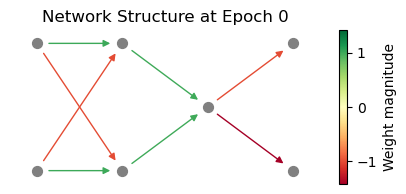

Visualizing sample 1/4...


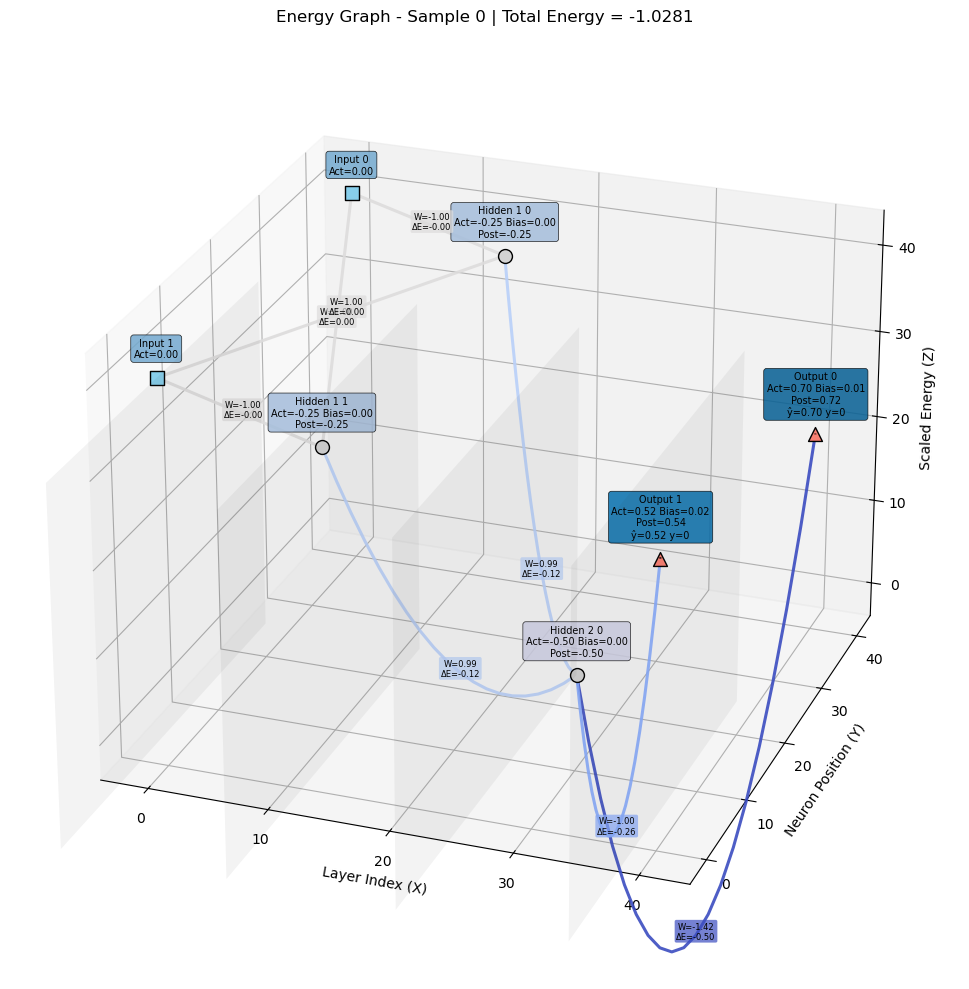

Visualizing sample 2/4...


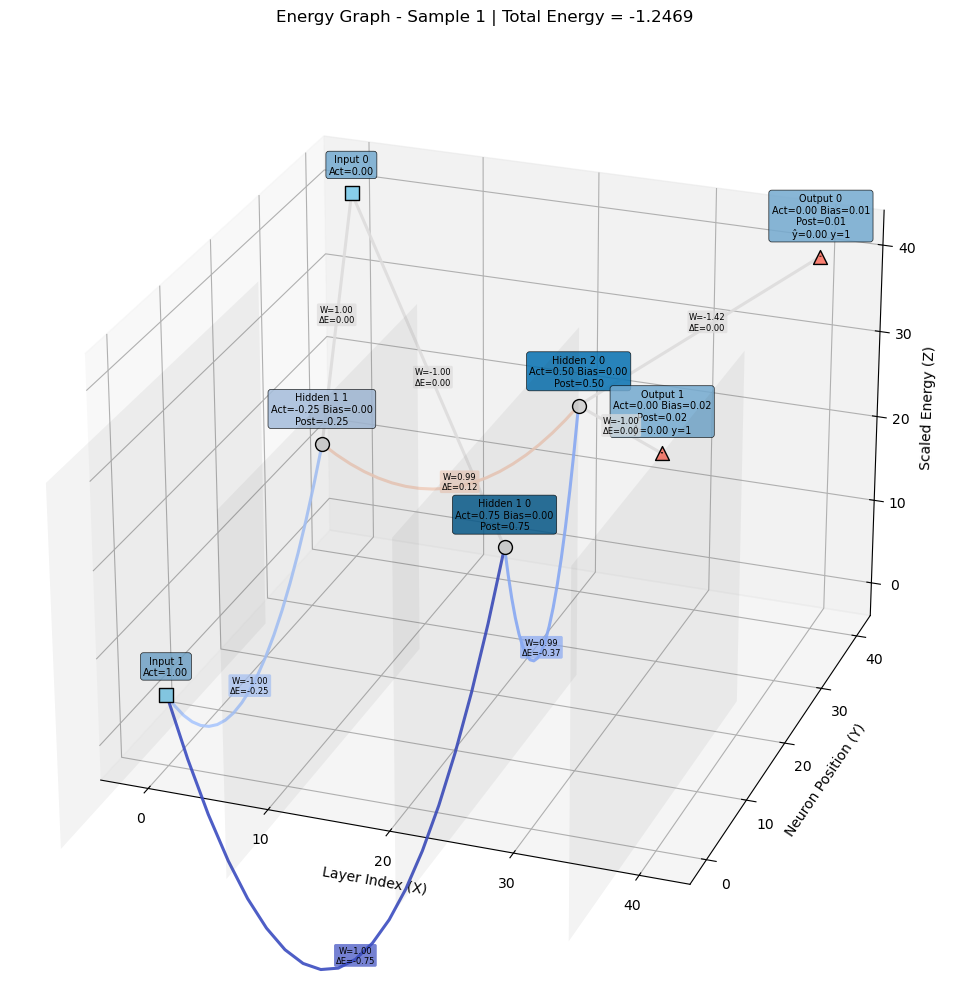

Visualizing sample 3/4...


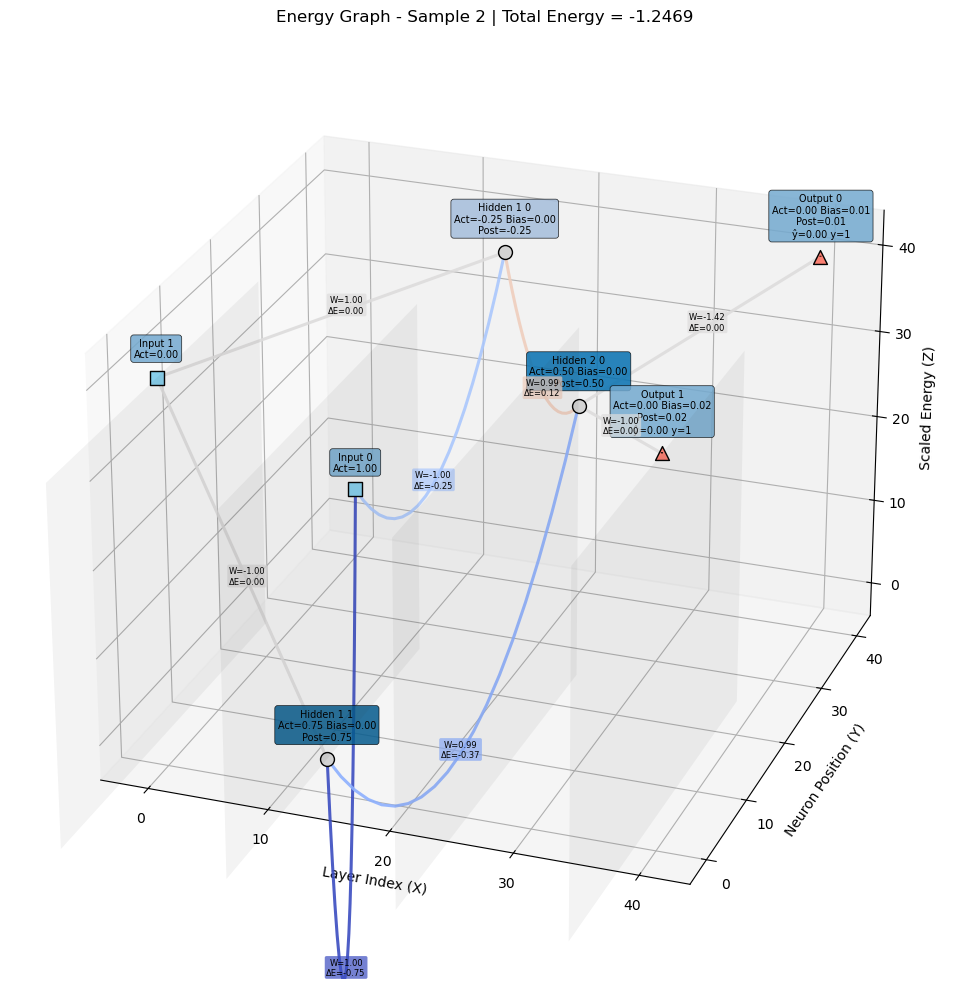

Visualizing sample 4/4...


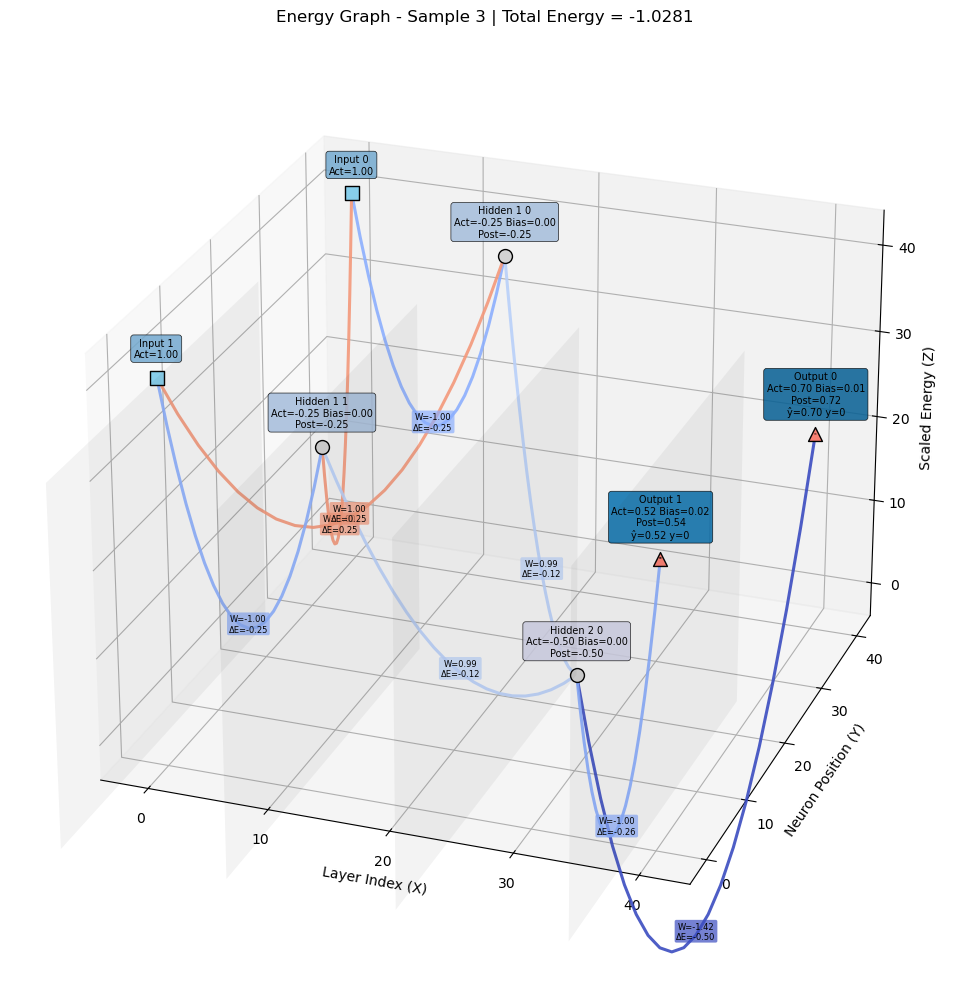

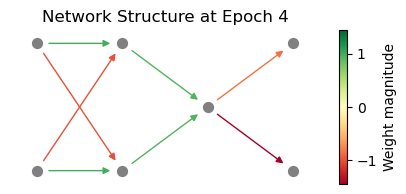

Visualizing sample 1/4...


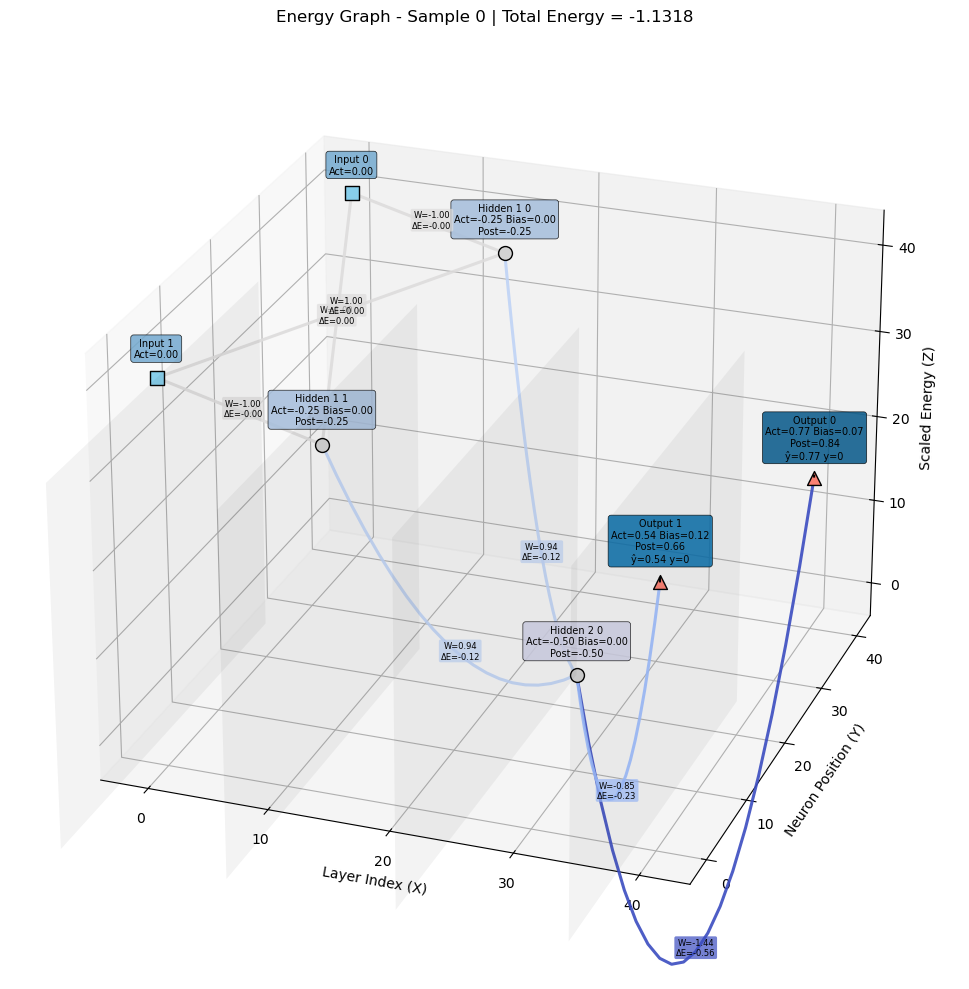

Visualizing sample 2/4...


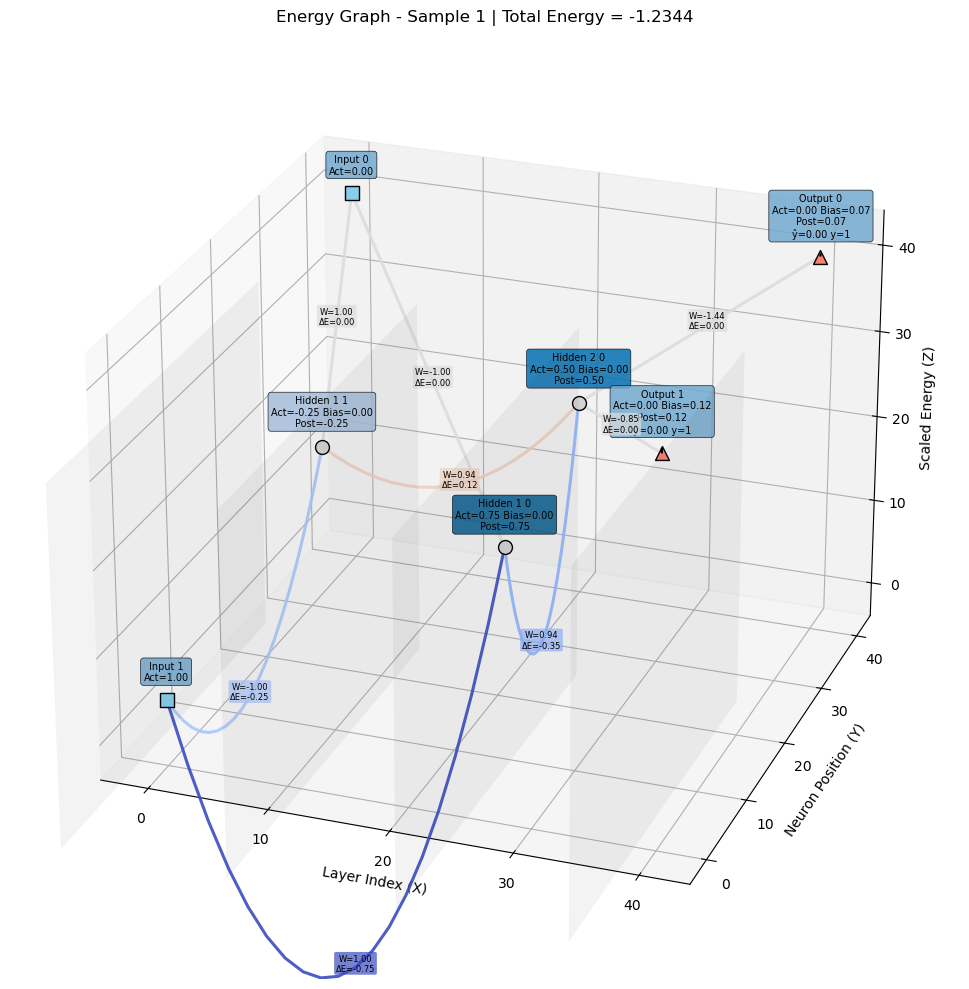

Visualizing sample 3/4...


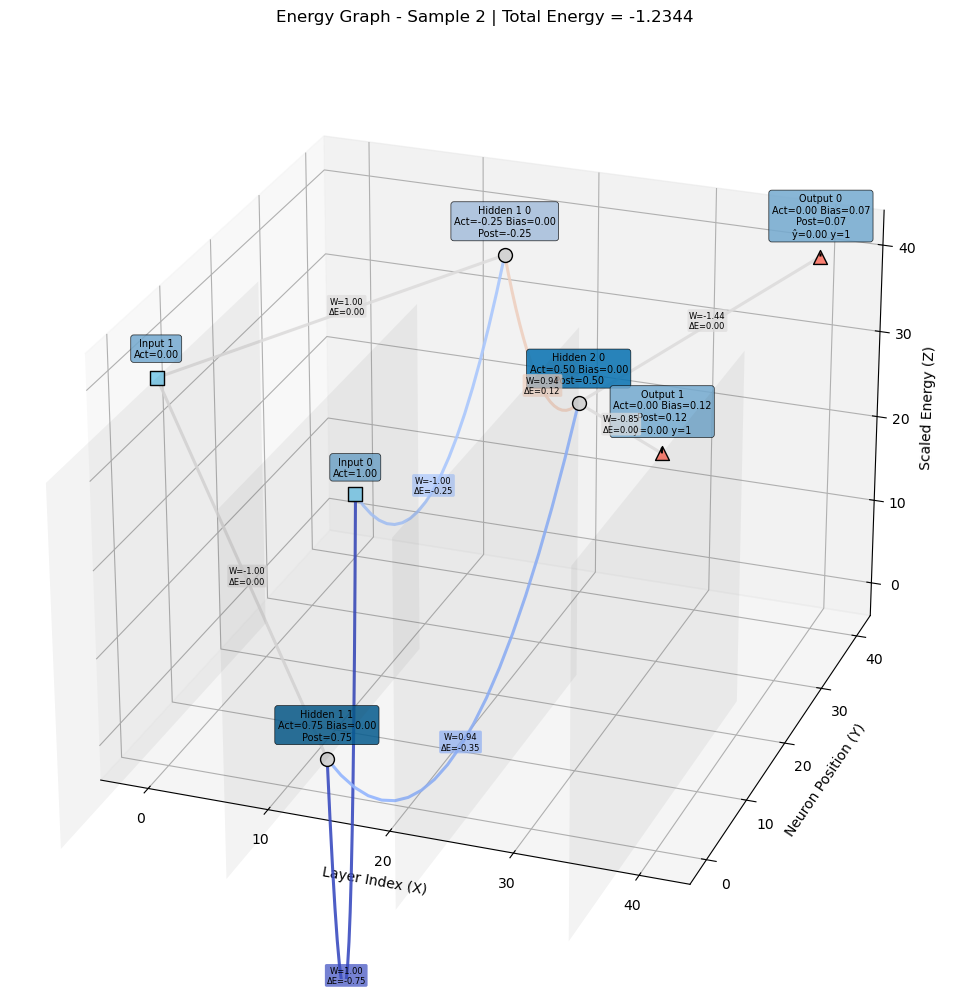

Visualizing sample 4/4...


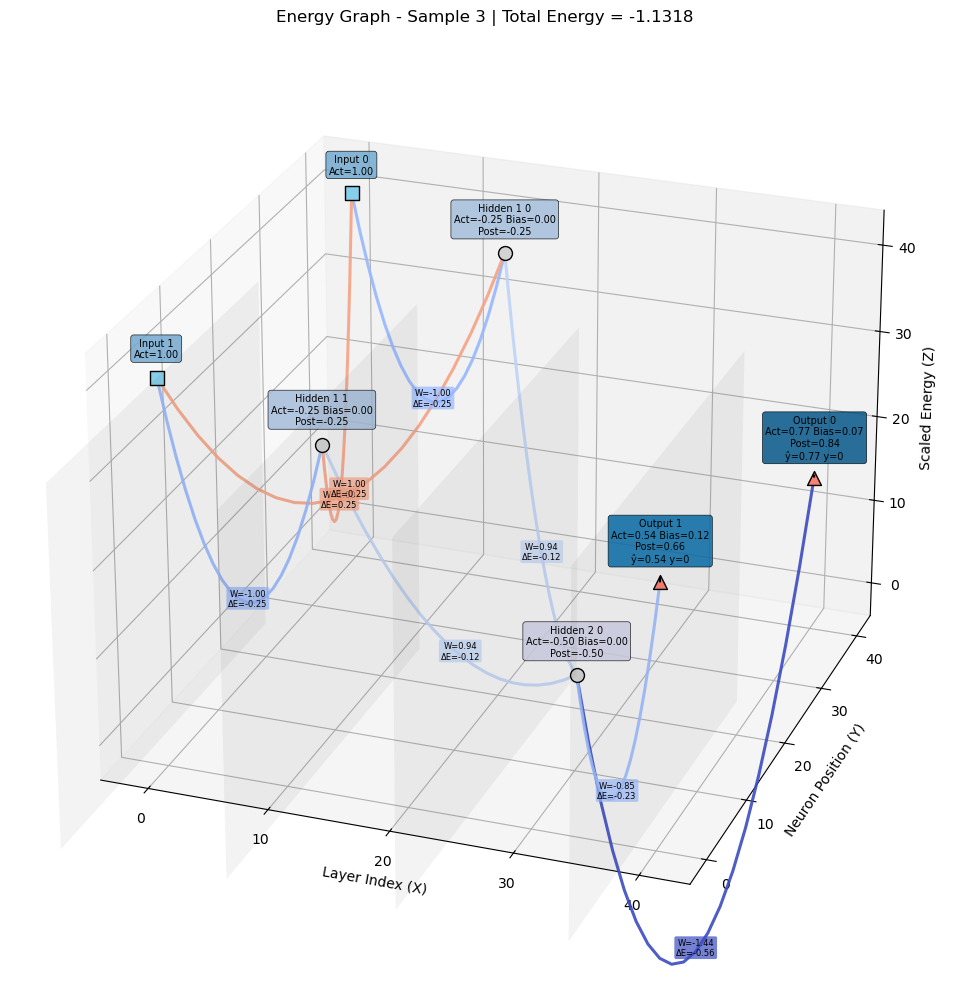

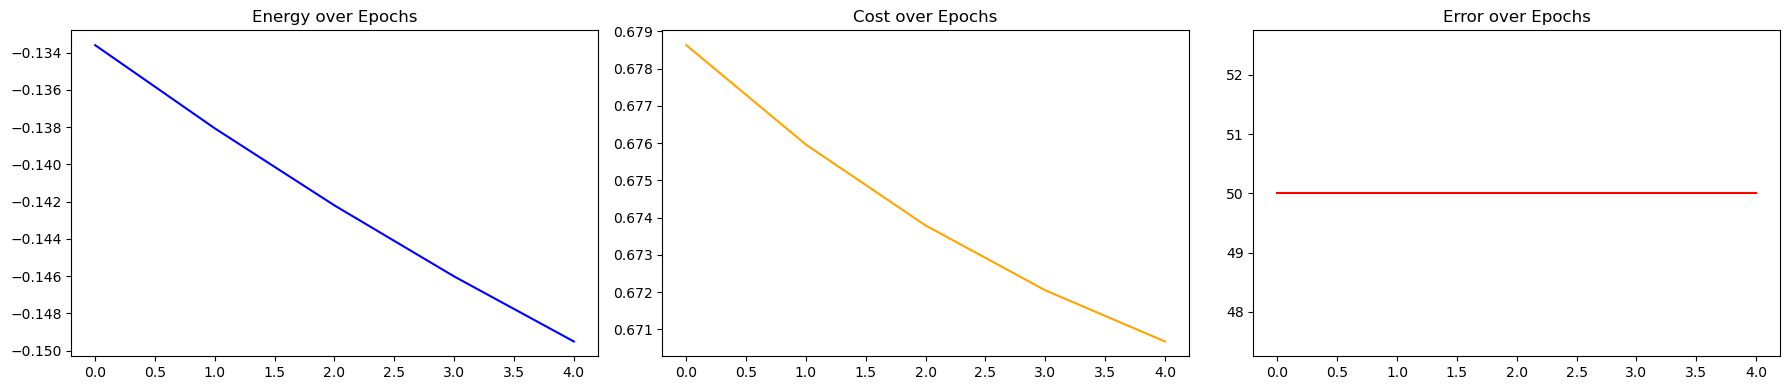

err 50.0
[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.7715, 0.5377],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.7715, 0.5377]])]
[tensor([0., 0.]), tensor([2.2352e-09, 2.2352e-09]), tensor([0.]), tensor([0.0653, 0.1178])]
[tensor([[-1.0000,  1.0000],
        [ 1.0000, -1.0000]]), tensor([[0.9375],
        [0.9375]]), tensor([[-1.4410, -0.8477]])]
[tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.7715, 0.5377],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.7715, 0.5377]])]


In [8]:
xor_net = Network(
            name=f"xor_trial",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 5,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1,0.1,0.1],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

init = [-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)


# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= True))
# print("Total layer sum:", sum(l.sum() for l in xor_net.layers).item())
# print("Total weight sum:", sum(w.sum() for w in xor_net.weights).item())
# print("Total bias sum:", sum(b.sum() for b in xor_net.biases).item())

print(xor_net.layers)
print(xor_net.biases)
print(xor_net.weights)
print(xor_net.persistent_particles)


